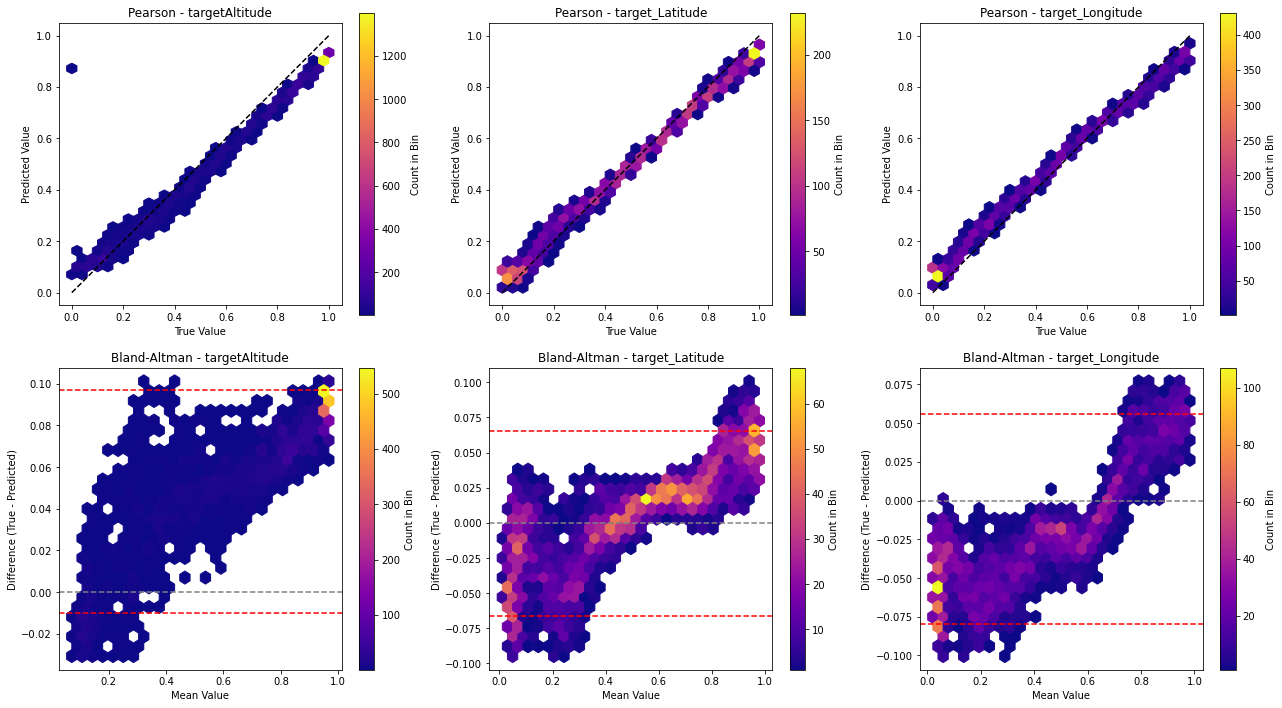

Label: targetAltitude


  0%|          | 0/1000 [00:00<?, ?it/s]

Label: target_Latitude


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import shap
import matplotlib.image as mpimg
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

##############################
## -- Core Project Class -- ##
##############################
class ECEN649Project():
  
  #################################
  ## -- initialize everything -- ##
  #################################
  def __init__(self):
    super(ECEN649Project, self).__init__()
    self.data = pd.read_pickle("./AAL598_2018-12-19-2019-02-08.pkl")
    
    self.PCA_ = self.PCA_(self)
    self.SVM_ = self.SVM_(self)
    self.LRM_ = self.LRM_(self)
    self.TBM_ = self.TBM_(self)
    
  ############################
  ## -- data prep method -- ##
  ############################
  def data_prep(self):
      
    X, y, X_keys, y_keys = [], [], None, None
    for idx, dataFrame in enumerate(self.data):
      X_data = dataFrame.drop(["arrivalPoint", "airline", "departurePoint", "targetAltitude", "actualPosition", 
                               "targetPosition", "target_Latitude", "target_Longitude"], axis = 1)
      y_data = dataFrame[["targetAltitude", "target_Latitude", "target_Longitude"]]

      X_data['actualPositionTime'] = pd.to_datetime(X_data['actualPositionTime'])
      X_data['actualPositionTime'] = X_data['actualPositionTime'].apply(lambda x: int(x.timestamp()))
      X_data['actualPositionTime'] = X_data['actualPositionTime'] - X_data['actualPositionTime'].iloc[0]

      scaler = MinMaxScaler()
      X_data = pd.DataFrame(scaler.fit_transform(X_data), columns = X_data.columns)
      y_data = pd.DataFrame(scaler.fit_transform(y_data), columns = y_data.columns)

      X_keys = X_data.keys()
      y_keys = y_data.keys()
      X_data = X_data.apply(lambda row: np.array(row.values), axis = 1)
      y_data = y_data.apply(lambda row: np.array(row.values), axis = 1)

      X.append(X_data)
      y.append(y_data)

    X = np.array(list(pd.concat(X).reset_index(drop = True)))
    y = np.array(list(pd.concat(y).reset_index(drop = True)))
    return X, y, X_keys, y_keys
  
  #######################
  ## -- PCA_ method -- ##
  #######################
  class PCA_():
    def __init__(self, parentProperties):
      self.data = parentProperties.data
      self.data_prep = parentProperties.data_prep
      
    def __call__(self):
      X, y, X_keys, y_keys = self.data_prep()
      scaler = StandardScaler()
      X_scaled = scaler.fit_transform(X)

      pca = PCA(n_components=min(X_scaled.shape[1], 10))
      X_pca = pca.fit_transform(X_scaled)
      explained_variance_ratio, cumulative_variance = pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_)
      df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
      sns.set_palette("plasma")

      fig, axes = plt.subplots(1, 3, figsize=(18, 5))
      hexbin_args = {'gridsize': 25, 'cmap': 'plasma', 'mincnt': 1}
      titles = ['PC1 vs PC2', 'PC1 vs PC3', 'PC2 vs PC3']
      for i, (pc1, pc2) in enumerate([(1, 2), (1, 3), (2, 3)]):
        hb = axes[i].hexbin(df_pca[f'PC{pc1}'], df_pca[f'PC{pc2}'], **hexbin_args)
        axes[i].set_xlabel(f'PC{pc1}', fontsize=12)
        axes[i].set_ylabel(f'PC{pc2}', fontsize=12)
        axes[i].set_title(f'{titles[i]} (Hexbin)', fontsize=14)
        fig.colorbar(hb, ax=axes[i]).set_label('Count in Bin')
      plt.tight_layout()
      plt.show()

      plt.figure(figsize = (8, 5))
      plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='tab:blue', markersize=6)
      plt.title('Cumulative Variance Explained by Principal Components', fontsize=14)
      plt.xlabel('Number of Principal Components', fontsize=12)
      plt.ylabel('Cumulative Explained Variance', fontsize=12)
      plt.xticks(range(1, len(cumulative_variance) + 1))
      plt.grid(True)
      plt.tight_layout()
      plt.show()

      print("Explained Variance Ratio:", explained_variance_ratio)
      print("Cumulative Variance Explained:", cumulative_variance)

      loadings_df = pd.DataFrame(pca.components_, columns=[f"> {X_keys[i]}".ljust(24) for i in range(X.shape[1])])
      for i, pc in enumerate(loadings_df.index):
        print(f"\nTop features contributing to PC{i+1}")
        for feature, contribution in loadings_df.iloc[pc].abs().sort_values(ascending=False).items():
          print(f"{feature}: {contribution:.4f}")


      
  #######################
  ## -- SVM_ method -- ##
  #######################
  class SVM_():
    def __init__(self, parentProperties):
      self.data = parentProperties.data
      self.data_prep = parentProperties.data_prep

    def remove_outliers(self, data):
      Q1 = np.percentile(data, 25)
      Q3 = np.percentile(data, 75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      return data[(data >= lower_bound) & (data <= upper_bound)]
  
    def shap_analysis(self, X_train, X_keys, y_keys, svm_models, X, background_size=100, sample_size=1000, n_jobs=4):
      if isinstance(X, pd.DataFrame):
        feature_names = X.columns
      else:
        feature_names = [f"{X_keys[i]}" for i in range(X_train.shape[1])]

      temp_dir = "shap_summary_plots"
      os.makedirs(temp_dir, exist_ok=True)

      if X_train.shape[0] > sample_size:
        indices = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
        X_train = X_train[indices]

      for i in range(len(svm_models)):
        print(f"Label: {y_keys[i]}")
        background = shap.kmeans(X_train, background_size)
        explainer = shap.KernelExplainer(svm_models[i].predict, background, link="identity")
        shap_values = explainer.shap_values(X_train, nsamples=50, n_jobs=n_jobs)

        shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=False)
        plt.savefig(f"{temp_dir}/shap_summary_{i}.png", dpi = 500)
        plt.close()

      fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi = 500)
      for i in range(3):
        img = mpimg.imread(f"{temp_dir}/shap_summary_{i}.png")
        axes[i].set_title(f"{y_keys[i]}", fontsize = 16)
        axes[i].imshow(img)
        axes[i].axis('off')

      plt.tight_layout()
      plt.show()

      import shutil
      shutil.rmtree(temp_dir)

    def __call__(self):
      X, y, X_keys, y_keys = self.data_prep()
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
      svm_models = [SVR(kernel='rbf') for _ in range(y.shape[1])]
      y_pred = np.zeros_like(y_test)

      for i, model in enumerate(svm_models):
        model.fit(X_train, y_train[:, i])
        y_pred[:, i] = model.predict(X_test)

      fig, axes = plt.subplots(2, 3, figsize=(18, 10))
      for i in range(3):
        # Pearson Correlation - Hexbin Plot
        hb = axes[0, i].hexbin(y_test[:, i], y_pred[:, i], gridsize=25, cmap='plasma', mincnt=1)
        axes[0, i].set_xlabel('True Value')
        axes[0, i].set_ylabel('Predicted Value')
        axes[0, i].set_title(f'Pearson - {y_keys[i]}')
        axes[0, i].plot([min(y_test[:, i]), max(y_test[:, i])], [min(y_test[:, i]), max(y_test[:, i])], color='black', linestyle='--')
        axes[0, i].set_aspect('equal', 'box')  # Equal scaling for X and Y axis
        cb = fig.colorbar(hb, ax=axes[0, i])
        cb.set_label('Count in Bin')

        # Bland-Altman Plot with Hexbin
        diff = y_test[:, i] - y_pred[:, i]
        diff_cleaned = self.remove_outliers(diff)
        mean_val = np.mean([y_test[:, i], y_pred[:, i]], axis=0)
        mean_val = mean_val[(diff >= np.min(diff_cleaned)) & (diff <= np.max(diff_cleaned))]
        diff = diff_cleaned
        
        limit_of_agreement = 1.96 * np.std(diff)
        lower_limit = np.percentile(diff, 5)
        upper_limit = np.percentile(diff, 95)

        hb2 = axes[1, i].hexbin(mean_val, diff, gridsize=25, cmap='plasma', mincnt=1)
        axes[1, i].set_xlabel('Mean Value')
        axes[1, i].set_ylabel('Difference (True - Predicted)')
        axes[1, i].set_title(f'Bland-Altman - {y_keys[i]}')
        axes[1, i].axhline(0, color='gray', linestyle='--')
        axes[1, i].axhline(lower_limit, color='red', linestyle='--')
        axes[1, i].axhline(upper_limit, color='red', linestyle='--')
        cb2 = fig.colorbar(hb2, ax=axes[1, i])
        cb2.set_label('Count in Bin')

      plt.tight_layout()
      plt.show()
      self.shap_analysis(X_train, X_keys, y_keys, svm_models, X)

          
  ####################################
  ## -- Linear Regression method -- ##
  ####################################
  class LRM_():
    def __init__(self, parentProperties):
      self.data = parentProperties.data
      self.data_prep = parentProperties.data_prep
    
    def __call__(self):
      X, y, X_keys, y_keys = self.data_prep()
      print("LRM_ TO BE IMPLEMENTED")
      pass
    
  #############################
  ## -- Tree Based method -- ##
  #############################
  class TBM_():
    def __init__(self, parentProperties):
      self.data = parentProperties.data
      self.data_prep = parentProperties.data_prep
    
    def __call__(self):
      X, y, X_keys, y_keys = self.data_prep()
      print("TBM_ TO BE IMPLEMENTED")
      pass

    

## -- Analysis -- ##
CORE = ECEN649Project()
# CORE.PCA_()
CORE.SVM_()
CORE.LRM_()
CORE.TBM_()